In [1]:
# conda debug enviornment is created to install latest open3d (0.16.0) with python 3.9

import osmnx as ox
import shapely.geometry.polygon
import geopandas as gpd
import elevation as dem
import rasterio as rio
from rasterio.warp import Resampling
from rasterio.plot import show
import richdem as rd
import utm
import open3d as o3d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# turn response caching off/on
ox.settings.use_cache = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<AxesSubplot: >

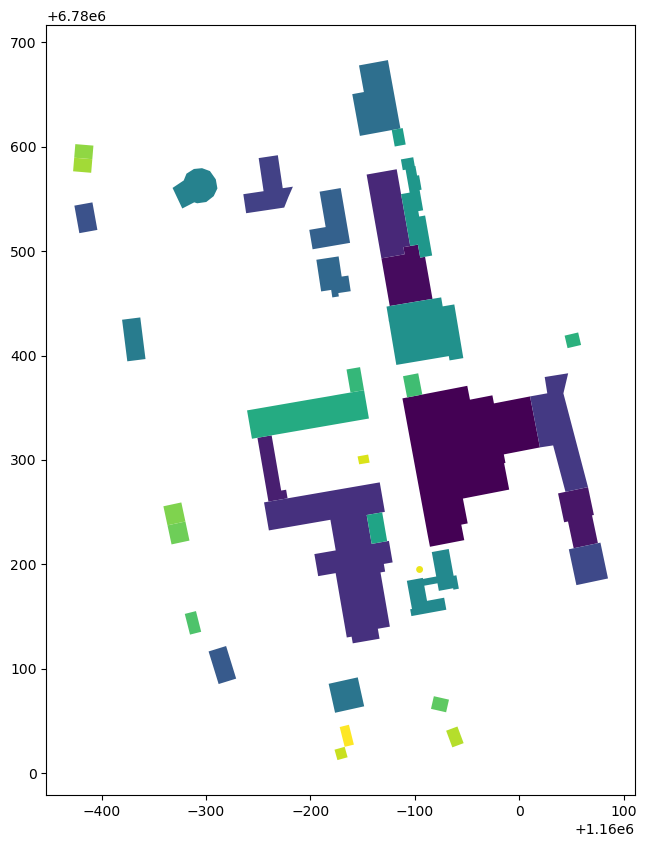

In [2]:
roi = (49.81061769757704, 9.988233595428222)
roi = (51.8903, 10.41933)
gdf = ox.geometries_from_point(roi, dist=200, tags={'building': True})
gdf = ox.projection.project_gdf(gdf, to_crs="EPSG:3857") # 4326, 3857
gdf.plot(color='red', alpha=1, cmap='viridis', figsize=(16,10))
# plt.gca().axis('off')

In [3]:
pcd = o3d.io.read_point_cloud("../map/pointcloud.pcd")
o3d.visualization.draw_geometries([pcd])

In [4]:
pts = np.asarray(pcd.points) # TO Numpy

for pt in pts:
    pt[2] = 0

pcd.points = o3d.utility.Vector3dVector(pts) # From Numpy
o3d.visualization.draw_geometries([pcd])


In [5]:
pts = np.asarray(pcd.points)  # TO Numpy

minxyz = pts.min(axis=0).astype(np.int16)
maxxyz = pts.max(axis=0).astype(np.int16)
# H, edges = np.histogramdd(pts, bins = (100, 100, 100))
H, _, _ = np.histogram2d(x=pts[:, 0], 
                         y=pts[:, 1], 
                         bins=[
                             np.arange(minxyz[0], maxxyz[0], 0.25), 
                             np.arange(minxyz[1], maxxyz[1], 0.25)
                             ], 
                         range=[
                             [minxyz[0], maxxyz[0]], 
                             [minxyz[1], maxxyz[1]]
                             ]
                         )

# Display as Pointcloud
# pcd1 = o3d.geometry.PointCloud()
# pcd1.points = o3d.utility.Vector3dVector(np.vstack(H))
# o3d.visualization.draw_geometries([pcd1])

# Export as Image
img = o3d.geometry.Image((H*10).astype(np.uint8))
o3d.io.write_image("../map/pointcloud.png", img)
o3d.visualization.draw_geometries([img])

In [6]:
mesh_box = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)
mesh_box.compute_vertex_normals()
mesh_box.paint_uniform_color([0.9, 0.1, 0.1])
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
mesh_sphere.compute_vertex_normals()
mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])
mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.3,
                                                            height=4.0)
mesh_cylinder.compute_vertex_normals()
mesh_cylinder.paint_uniform_color([0.1, 0.9, 0.1])
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[-2, -2, -2])

print("We draw a few primitives using collection.")
o3d.visualization.draw_geometries(
    [mesh_box, mesh_sphere, mesh_cylinder, mesh_frame])

# print("We draw a few primitives using + operator of mesh.")
# o3d.visualization.draw_geometries(
#     [mesh_box + mesh_sphere + mesh_cylinder + mesh_frame])

# print("Let's draw a cubic using o3d.geometry.LineSet.")
# points = [
#     [0, 0, 0],
#     [1, 0, 0],
#     [0, 1, 0],
#     [1, 1, 0],
#     [0, 0, 1],
#     [1, 0, 1],
#     [0, 1, 1],
#     [1, 1, 1],
# ]
# lines = [
#     [0, 1],
#     [0, 2],
#     [1, 3],
#     [2, 3],
#     [4, 5],
#     [4, 6],
#     [5, 7],
#     [6, 7],
#     [0, 4],
#     [1, 5],
#     [2, 6],
#     [3, 7],
# ]
# colors = [[1, 0, 0] for i in range(len(lines))]
# line_set = o3d.geometry.LineSet(
#     points=o3d.utility.Vector3dVector(points),
#     lines=o3d.utility.Vector2iVector(lines),
# )
# line_set.colors = o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw_geometries([line_set])

We draw a few primitives using collection.


In [7]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)
# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
cube_id = scene.add_triangles(cube)
rays = o3d.core.Tensor([[0.5, 0.5, 10, 0, 0, -1], [-1, -1, -1, 0, 0, -1]],
                       dtype=o3d.core.Dtype.Float32)
ans = scene.cast_rays(rays)
print(ans['t_hit'])
print(ans['geometry_ids'])
print(ans['primitive_uvs'])
print(ans['t_hit'].numpy(), "\n", ans['primitive_uvs'].numpy())

[9.0 inf]
Tensor[shape={2}, stride={1}, Float32, CPU:0, 0x34abc60]
[0 4294967295]
Tensor[shape={2}, stride={1}, UInt32, CPU:0, 0x4c1ff80]
[[-0.0 0.5],
 [0.0 0.0]]
Tensor[shape={2, 2}, stride={2, 1}, Float32, CPU:0, 0x4e46380]
[8.999999      inf] 
 [[-0.          0.49999997]
 [ 0.          0.        ]]


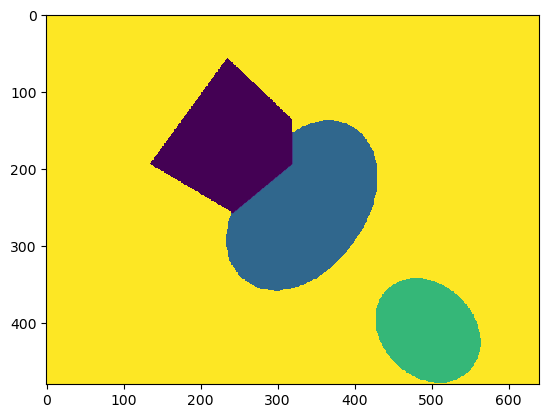

In [8]:
# Create meshes and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([0, 0, 0])
cube = o3d.t.geometry.TriangleMesh.from_legacy(cube)
torus = o3d.geometry.TriangleMesh.create_torus().translate([0, 0, 2])
torus = o3d.t.geometry.TriangleMesh.from_legacy(torus)
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5).translate(
    [1, 2, 3])
sphere = o3d.t.geometry.TriangleMesh.from_legacy(sphere)

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(cube)
scene.add_triangles(torus)
_ = scene.add_triangles(sphere)

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[0, 0, 2],
    eye=[2, 3, 0],
    up=[0, 1, 0],
    width_px=640,
    height_px=480,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)
plt.imshow(ans['t_hit'].numpy())
plt.imshow(np.abs(ans['primitive_normals'].numpy()))
plt.imshow(ans['geometry_ids'].numpy(), vmax=3)

In [9]:
hit = ans['t_hit'].isfinite()
points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
pcd = o3d.t.geometry.PointCloud(points)
# Press Ctrl/Cmd-C in the visualization window to copy the current viewpoint
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  front=[0.5, 0.86, 0.125],
                                  lookat=[0.23, 0.5, 2],
                                  up=[-0.63, 0.45, -0.63],
                                  zoom=0.7)
# o3d.visualization.draw([pcd]) # new API

In [10]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh
armadillo_data = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo_data.path)
o3d.visualization.draw_geometries([mesh])
mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)

# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh

In [11]:
query_point = o3d.core.Tensor([[10, 10, 10]], dtype=o3d.core.Dtype.Float32)

# Compute distance of the query point from the surface
unsigned_distance = scene.compute_distance(query_point)
signed_distance = scene.compute_signed_distance(query_point)
occupancy = scene.compute_occupancy(query_point)
print("unsigned distance", unsigned_distance.numpy())
print("signed_distance", signed_distance.numpy())
print("occupancy", occupancy.numpy())

unsigned distance [7.8694816]
signed_distance [-7.8694816]
occupancy [1.]


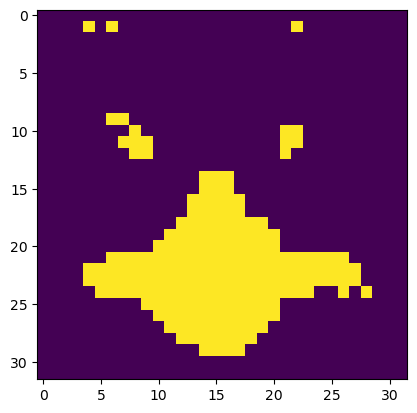

In [12]:
min_bound = mesh.vertex.positions.min(0).numpy()
max_bound = mesh.vertex.positions.max(0).numpy()

N = 256
query_points = np.random.uniform(low=min_bound, high=max_bound,
                                 size=[N, 3]).astype(np.float32)

# Compute the signed distance for N random points
signed_distance = scene.compute_signed_distance(query_points)

xyz_range = np.linspace(min_bound, max_bound, num=32)

# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

# signed distance is a [32,32,32] array
signed_distance = scene.compute_signed_distance(query_points)
unsigned_distance = scene.compute_distance(query_points)
occupancy = scene.compute_occupancy(query_points)

# We can visualize a slice of the distance field directly with matplotlib
plt.imshow(occupancy.numpy()[:, :, 15])

In [13]:
cube = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_box().translate([-1.2, -1.2, 0]))
sphere = o3d.t.geometry.TriangleMesh.from_legacy(
    o3d.geometry.TriangleMesh.create_sphere(0.5).translate([0.7, 0.8, 0]))

scene = o3d.t.geometry.RaycastingScene()
# Add triangle meshes and remember ids
mesh_ids = {}
mesh_ids[scene.add_triangles(cube)] = 'cube'
mesh_ids[scene.add_triangles(sphere)] = 'sphere'

query_point = o3d.core.Tensor([[0, 0, 0]], dtype=o3d.core.Dtype.Float32)

# We compute the closest point on the surface for the point at position [0,0,0].
ans = scene.compute_closest_points(query_point)

# Compute_closest_points provides the point on the surface, the geometry id,
# and the primitive id.
# The dictionary keys are
#.    points
#.    geometry_ids
#.    primitive_ids
print('The closest point on the surface is', ans['points'].numpy())
print('The closest point is on the surface of the',
      mesh_ids[ans['geometry_ids'][0].item()])
print('The closest point belongs to triangle', ans['primitive_ids'][0].item())

The closest point on the surface is [[-0.2 -0.2  0. ]]
The closest point is on the surface of the cube
The closest point belongs to triangle 0


In [14]:
rays = np.concatenate(
    [query_point.numpy(),
     np.ones(query_point.shape, dtype=np.float32)],
    axis=-1)
intersection_counts = scene.count_intersections(rays).numpy()
# A point is inside if the number of intersections with the scene is even
# This sssumes that inside and outside is we ll defined for the scene.
is_inside = intersection_counts % 2 == 1

In [15]:
def compute_signed_distance_and_closest_goemetry(query_points: np.ndarray):
    closest_points = scene.compute_closest_points(query_points)
    distance = np.linalg.norm(query_points - closest_points['points'].numpy(),
                              axis=-1)
    rays = np.concatenate([query_points, np.ones_like(query_points)], axis=-1)
    intersection_counts = scene.count_intersections(rays).numpy()
    is_inside = intersection_counts % 2 == 1
    distance[is_inside] *= -1
    return distance, closest_points['geometry_ids'].numpy()

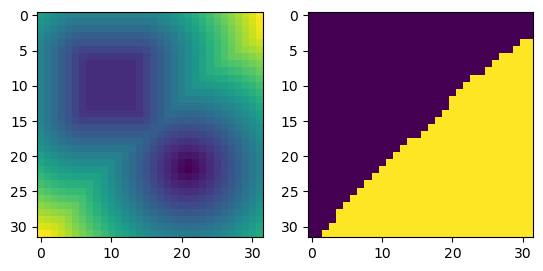

In [16]:
# compute range
xyz_range = np.linspace([-2, -2, -2], [2, 2, 2], num=32)
# query_points is a [32,32,32,3] array ..
query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

sdf, closest_geom = compute_signed_distance_and_closest_goemetry(query_points)

# We can visualize a slice of the grids directly with matplotlib
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sdf[:, :, 16])
axes[1].imshow(closest_geom[:, :, 16])

In [17]:
# o3d.t.geometry.RaycastingScene.create_rays_pinhole?
dataset = o3d.data.PCDPointCloud()
# dataset = o3d.data.EaglePointCloud()
# dataset = o3d.data.LivingRoomPointClouds()
# dataset = o3d.data.OfficePointClouds()
# dataset = o3d.data.BunnyMesh()
# dataset = o3d.data.ArmadilloMesh()
# dataset = o3d.data.KnotMesh()
# dataset = o3d.data.MonkeyModel()
# dataset = o3d.data.SwordModel()
# dataset = o3d.data.CrateModel()
# dataset = o3d.data.FlightHelmetModel()
# dataset = o3d.data.AvocadoModel()
# dataset = o3d.data.DamagedHelmetModel()
# img_data = o3d.data.JuneauImage()
# dataset = o3d.data.SampleRedwoodRGBDImages()
# dataset = o3d.data.SampleFountainRGBDImages()
# dataset = o3d.data.SampleSUNRGBDImage()
# dataset = o3d.data.SampleTUMRGBDImage()
# dataset = o3d.data.LoungeRGBDImages()
# dataset = o3d.data.BedroomRGBDImages()
# dataset = o3d.data.DemoICPPointClouds()
# dataset = o3d.data.DemoColoredICPPointClouds()
# dataset = o3d.data.DemoCropPointCloud()
# dataset = o3d.data.DemoFeatureMatchingPointClouds()
# dataset = o3d.data.DemoPoseGraphOptimization()
# dataset = o3d.data.RedwoodIndoorLivingRoom1()
# dataset = o3d.data.RedwoodIndoorLivingRoom2()
# dataset = o3d.data.RedwoodIndoorOffice1()
# dataset = o3d.data.RedwoodIndoorOffice2()
pcd = o3d.io.read_point_cloud(dataset.path)
o3d.visualization.draw_geometries([pcd])


In [18]:
# camera_rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
#     fov_deg=90,
#     center=[0, 0, 2],
#     eye=[2, 3, 0],
#     up=[0, 1, 0],
#     width_px=640,
#     height_px=480,
# )
# camera_rays

In [19]:
def lidar_model(vfov = 30, hres=1, vres=1):
    direction = []
    for theta in np.arange(0, 2*np.pi, hres*np.pi/180.0):
        for phi in np.arange(-(vfov/2.0)*np.pi/180.0 + np.pi/2, (vfov/2.0)*np.pi/180.0 + np.pi/2, vres*np.pi/180.0):
            x = np.sin(phi) * np.cos(theta)
            y = np.sin(phi) * np.sin(theta)
            z = np.cos(phi)
            direction.append([x, y, z])
    return direction

def lidar_scan(pos, model):
    pts = [[pos[0], pos[1], pos[2], dir[0], dir[1], dir[2]] for dir in model] 
    return o3d.core.Tensor(pts, dtype=o3d.core.Dtype.Float32)

vpl16_model = lidar_model(30, 1, 1)

pcd = o3d.geometry.PointCloud()
vpl16_model = lidar_model(30, 0.2, 1)
pcd.points = o3d.utility.Vector3dVector(vpl16_model)
o3d.visualization.draw_geometries([pcd])


In [20]:
# Load mesh and convert to open3d.t.geometry.TriangleMesh
cube = o3d.geometry.TriangleMesh.create_box().translate([5, 5, 0])
cube.compute_vertex_normals()
cube.paint_uniform_color([0.9, 0.2, 0.2])

# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
cube_id = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cube))
vpl16_model = lidar_model(vfov=30, hres=0.2, vres=1)
rays = lidar_scan([0.01, 0.01, 0.01], vpl16_model)
ans = scene.cast_rays(rays)

hit =  (ans['t_hit'] < 10) # ans['t_hit'].isfinite()
points = rays[hit][:,:3] + rays[hit][:,3:] * ans['t_hit'][hit].reshape((-1,1))
pcd = o3d.t.geometry.PointCloud(points)
# Press Ctrl/Cmd-C in the visualization window to copy the current viewpoint
o3d.visualization.draw_geometries([pcd.to_legacy()])


In [21]:
pts = []
pt0 = None
for g in gdf.geometry:
    for pt in g.exterior.coords:
        if pt0 is None:
            pt0 = pt
            pts.append([0, 0, 0])
        else:
            pts.append([pt[0]-pt0[0], pt[1]-pt0[1], 0])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
# pcd = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
# o3d.geometry.compute_point_cloud_convex_hull(pcd)
cvxhull, _ = pcd.compute_convex_hull(True)
cvxhull.compute_vertex_normals()
cvxhull.paint_uniform_color([0.9, 0.1, 0.1])
# o3d.visualization.draw_geometries([pcd])
o3d.visualization.draw_geometries([cvxhull])
# pcd.compute_convex_hull?

# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 0.03)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd)
# o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pts)


Qhull messages at ~Qhull()
QH7089 qhull precision warning: The initial hull is narrow.  Is the input lower
dimensional (e.g., a square in 3-d instead of a cube)?  Cosine of the minimum
angle is 1.0000000000000000.  If so, Qhull may produce a wide facet.
Options 'Qs' (search all points), 'Qbb' (scale last coordinate), or
'QbB' (scale to unit box) may remove this warning.
See 'Limitations' in qh-impre.htm.  Use 'Pp' to skip this warning.


In [22]:
pts = [
    [1, 1, 1],
    [2, 1, 1],
    [2, 2, 1],
    [1, 2, 1],
    [1, 1, 2],
    [2, 1, 2],
    [2, 2, 2],
    [1, 2, 2],
]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
cvxhull, _ = pcd.compute_convex_hull(True)
cvxhull.compute_vertex_normals()
cvxhull.paint_uniform_color([0.9, 0.1, 0.1])
o3d.visualization.draw_geometries([cvxhull])


In [23]:
meshes = []

for g in gdf.geometry:
    try:
        cvxhull = None
        pts = []
        for pt in g.exterior.coords:
            pts.append([pt[0], pt[1], 0])
            pts.append([pt[0], pt[1], 10])
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts)
        pcd.estimate_normals()
        # cvxhull, _ = pcd.compute_convex_hull(True)
        # cvxhull = pcd.TetraMesh.PointCloud(pcd)
        cvxhull = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector([1, 2, 4, 8, 16, 32]))
        # cvxhull, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd)
        # cvxhull.compute_vertex_normals()
        cvxhull.paint_uniform_color([np.random.random_sample(), np.random.random_sample(), np.random.random_sample()])        
        meshes.append(cvxhull)
        
    except Exception as ex:
        print(f"Exception: {ex}")       
        pass

o3d.visualization.draw_geometries(meshes)
print(len(meshes))

37


In [24]:
from scipy.spatial import Delaunay
import open3d as o3d
import numpy as np

pts = [
    [1, 1, 1],
    [2, 1, 1],
    [2, 2, 1],
    [1, 2, 1],
    [1, 1, 2],
    [2, 1, 2],
    [2, 2, 2],
    [1, 2, 2],
]

tri = Delaunay(pts)
vtx = []
for face in tri.simplices:
    vtx.append([face[0], face[1], face[2]])
    vtx.append([face[1], face[2], face[3]])
    
mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(pts), 
                                 o3d.utility.Vector3iVector(vtx))
mesh.vertex_colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(pts), 3)))
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True, point_show_normal=True, mesh_show_wireframe=True, window_name="Playground")
tri.vertices

/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[6, 3, 4, 0],
       [6, 2, 1, 0],
       [6, 4, 1, 0],
       [6, 3, 2, 0],
       [6, 5, 4, 1],
       [6, 7, 3, 4]], dtype=int32)

In [23]:
def extrude_polygon_sides(pg, height=1):
    vtx = pg.copy()  # copy original ist
    tri_idx = []
    N = len(pg)
    for idx in range(0, N-1):
        pt = pg[idx]
        vtx.append([pt[0], pt[1], pt[2]+height])  # Add extruded point
        tri_idx.append([idx, idx+1, N+idx])
        tri_idx.append([idx+1, N+idx+1, N+idx])
    # Add last point
    pt = pg[-1]
    vtx.append([pt[0], pt[1], pt[2]+height])  # Add extruded point
    return vtx, tri_idx


def get_osm_buildings_with_dem(roi=(51.8903, 10.41933), zone_num=32, zone_letter='U', upscale_factor = 30):

    # Get OSM
    gdf = ox.geometries_from_point(roi, dist=200, tags={'building': True})
    print('Bbox: ', gdf.total_bounds)

    # Get DEM
    offset = 0.0005
    bbx = gdf.total_bounds
    bbx = (bbx[0]-offset, bbx[1]-offset, bbx[2]+offset, bbx[3]+offset)

    fname = f"{os.getcwd()}/ROI-DEM.tif"
    dem.clip(bounds=(bbx[0], bbx[1], bbx[2], bbx[3]),
             output=fname, product='SRTM1')
    dem.clean()  # clean up stale temporary files and fix the cache in the event of a server error
    dem_data = rio.open(fname)

    # Resample DEM
    dem_array = dem_data.read(1,
                              out_shape=(int(dem_data.height * upscale_factor),
                                         int(dem_data.width * upscale_factor)),
                              out_dtype=np.double,
                              resampling=Resampling.bilinear
                              )

    # DEM image transform
    dem_transform = dem_data.transform * dem_data.transform.scale(
        (dem_data.width / dem_array.shape[-1]),
        (dem_data.height / dem_array.shape[-2])
    )

    # Get elevation at pt(lng, lat) and convert to utm
    start_lng_lat = gdf.loc[gdf.index[0]].geometry.exterior.coords[0]
    start_alt = dem_array[rio.transform.rowcol(
        dem_transform, start_lng_lat[0], start_lng_lat[1])]
    start_east, start_north, _, _ = utm.from_latlon(
        start_lng_lat[1], start_lng_lat[0], zone_num, zone_letter)  # Note lat, lng order
    start_pt = [start_east, start_north, start_alt]
    print(start_pt)
    geoms = []
    ground = []
    for geom in gdf.geometry:
        pts = []
        for pt in geom.exterior.coords:
            lng = pt[0]
            lat = pt[1]
            alt = dem_array[rio.transform.rowcol(dem_transform, lng, lat)]
            east, north, _, _ = utm.from_latlon(
                lat, lng, zone_num, zone_letter)
            # abs_pos = [east, north, alt]
            rel_pos = [east-start_pt[0], north-start_pt[1], alt-start_pt[2]]
            pts.append(rel_pos)
            ground.append(rel_pos)

        geoms.append(pts)


    return geoms, ground


def show_dem(fname=f"{os.getcwd()}/ROI-DEM.tif", upscale_factor=30):
    with rio.open(fname) as dem_data:
        # dem_array = dem_data.read(1).astype('float64')
        dem_array = dem_data.read(1,
                                  out_shape=(int(dem_data.height * upscale_factor),
                                             int(dem_data.width * upscale_factor)),
                                  out_dtype=np.double,
                                  resampling=Resampling.bilinear
                                  )

        dem_richdem = rd.rdarray(dem_array, no_data=-9999)
        fig = rd.rdShow(dem_richdem, axes=False,
                        cmap='viridis', figsize=(12, 10))
    return fig


def dem_coordinates(fname=f"{os.getcwd()}/ROI-DEM.tif", upscale_factor=30):
    with rio.open(fname) as dem_data:
        # band1 = dem_data.read(1).astype('float64')
        band1 = dem_data.read(1,
                              out_shape=(int(dem_data.height * upscale_factor),
                                         int(dem_data.width * upscale_factor)),
                              out_dtype=np.double,
                              resampling=Resampling.bilinear
                              )
        print('Band1 has shape', band1.shape)
        height = band1.shape[0]
        width = band1.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rio.transform.xy(dem_data.transform, rows, cols)
        lngs = np.array(xs)
        lats = np.array(ys)
        pts = []
        for y, lat in enumerate(lats[0, 50:-50]):
            for x, lng in enumerate(lngs[0, 50:-50]):
                pts.append([lng, lat, band1[(x, y)]])
    return lats, lngs, pts


def create_open3d_waypoints(points: list(), color=[1,0,0]):
    """Create Open3D Lineset from given list of points

    Args:
        points (list(list([x,y,z]))): List of lists containing points Cartesian coordinates [x,y,z]
        color (list, optional): Color [R, G, B]. Defaults to [1,0,0].

    Returns:
        LineSet: Open3D LineSet object
    """
    lines = [[idx-1, idx] for idx in range(1,len(points))] # Create consective point as line
    colors = [color for i in range(len(lines))]
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(points)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    # o3d.visualization.draw_geometries([line_set])
    # mesh = line_set.extrude_linear([0,1,0])
    # o3d.visualization.draw_geometries([mesh])
    return line_set


In [139]:
# show_dem(upscale_factor=1)
# lats, lngs, pts = dem_coordinates();

Band1 has shape (510, 600)


In [22]:
buildings, ground = get_osm_buildings_with_dem(roi=(51.8903, 10.41933)); # Rammelsberg
# buildings, ground = get_osm_buildings_with_dem(roi=(49.7809210875775, 9.975194325565797)); # Robotics Hall
# buildings, ground = get_osm_buildings_with_dem(roi=(49.801376484175385, 9.934727615561737)); # Wurzburg Hbf
# buildings, ground = get_osm_buildings_with_dem(roi=(49.81051384510241, 9.988340883784735)); # Lengfeld
# buildings

meshes = []
for building in buildings:
    vtx, tri_dix = extrude_polygon_sides(building, 15)
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vtx), o3d.utility.Vector3iVector(tri_dix))
    # mesh.vertex_colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(vtx), 3)))
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([np.random.random_sample(), np.random.random_sample(), np.random.random_sample()])        
    meshes.append(mesh)
        
ground_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(ground))
ground_pcd.estimate_normals()
ground_pcd.orient_normals_to_align_with_direction()
ground_mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(ground_pcd, depth=6)
# ground_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(ground_pcd, o3d.utility.DoubleVector([0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]))
ground_mesh.paint_uniform_color([np.random.random_sample(), np.random.random_sample(), np.random.random_sample()])        
meshes.append(ground_mesh)
o3d.visualization.draw_geometries(meshes, mesh_show_back_face=True, point_show_normal=True, mesh_show_wireframe=False, window_name=f"Playground: {len(meshes)}")

/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/ahmad/anaconda3/envs/debug/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bbox:  [10.416618  51.8886251 10.4212208 51.8923425]
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.e4a893739e9f418c889ff274b3d8e6ad.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 10.416117999999999 51.8928425 10.421720800000001 51.888125099999996 SRTM1.e4a893739e9f418c889ff274b3d8e6ad.vrt /home/ahmad/personal_ws/src/ROSExamples/script/ROI-DEM.tif
rm -f SRTM1.e4a893739e9f418c889ff274b3d8e6ad.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Enteri

ERROR 1: PROJ: proj_create_from_name: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed


[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

In [6]:
pts = [
    [1, 1, 1],
    [2, 1, 1],
    [2, 2, 1],
    [1, 2, 1],
    [1, 1, 1]
]
vtx, tri_dix = extrude_polygon_sides(pts, 1)
print(vtx)
print(tri_dix)
mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vtx), 
                                 o3d.utility.Vector3iVector(tri_dix))
mesh.vertex_colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(vtx), 3)))
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True, point_show_normal=True, mesh_show_wireframe=True, window_name="Playground")

[[1, 1, 1], [2, 1, 1], [2, 2, 1], [1, 2, 1], [1, 1, 1], [1, 1, 2], [2, 1, 2], [2, 2, 2], [1, 2, 2], [1, 1, 2]]
[[0, 1, 5], [1, 6, 5], [1, 2, 6], [2, 7, 6], [2, 3, 7], [3, 8, 7], [3, 4, 8], [4, 9, 8]]


In [49]:
# Get the overall bounding box
print(gdf.bounds.agg({'minx': 'min', 'miny': 'min', 'maxx': 'max', 'maxy': 'max'}).to_numpy())
print(gdf.total_bounds)

[1159572.61154805 6780012.44188353 1160084.99290027 6780682.95629068]
[1159573.61154805 6780013.44188353 1160085.99290027 6780683.95629068]


In [7]:
N = 5
vertices = o3d.utility.Vector3dVector(
    np.array([[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1], [0.5, 0.5, 0.5]]))
triangles = o3d.utility.Vector3iVector(
    np.array([[0, 1, 2], [0, 2, 3], [0, 4, 1], [1, 4, 2], [2, 4, 3],
                [3, 4, 0]]))
mesh_np = o3d.geometry.TriangleMesh(vertices, triangles)
mesh_np.vertex_colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
mesh_np.compute_vertex_normals()

print(np.asarray(mesh_np.triangle_normals))
print("Displaying mesh made using numpy ...")
o3d.visualization.draw_geometries([mesh_np])

[[ 0.         -1.          0.        ]
 [ 0.         -1.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.70710678  0.70710678 -0.        ]
 [ 0.          0.70710678  0.70710678]
 [-0.70710678  0.70710678  0.        ]]
Displaying mesh made using numpy ...


In [8]:
# cube = o3d.geometry.TriangleMesh.create_box().translate([10, 10, 10])
# cube.compute_vertex_normals()
# cube.paint_uniform_color([0.9, 0.1, 0.1])
# scene = o3d.t.geometry.RaycastingScene()
# cube_id = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cube))

# rays = o3d.core.Tensor([
#     [0.01, 0.01, 0.01, 1, 1, 1],
#     [0.01, 0.01, 0.01, 1.5, 1.5, 1]
# ],
#     dtype=o3d.core.Dtype.Float32)

# # ans = scene.cast_rays(rays)
# hit = ans['t_hit'].isfinite()
# points = rays[hit][:, :3] + rays[hit][:, 3:]*ans['t_hit'][hit].reshape((-1, 1))
# points  # hit #ans

In [25]:
points = [[0, 0, 0], [10, 0, 0], [10, 100, 0], [20, 100, 0], [20, 0, 0], [30, 0, 0], [30, 100, 0], [40, 100, 0]]
ls = create_open3d_waypoints(points, [1,0,0])
o3d.visualization.draw_geometries([ls])
